In [1]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra

from phydra.processes.main import ThirdInit

from phydra.core.parts import Parameter

In [2]:
import xsimlab as xs

import numpy as np

In [3]:
import attr

from attr._make import _CountingAttr

In [4]:
from enum import Enum

class FluxVarType(Enum):
    STATEVARIABLE = "statevariable"
    PARAMETER = "parameter"
    FORCING = "forcing"

class FluxVarFlow(Enum):
    INPUT = "input"
    OUTPUT = "output"
    
class FluxVarIntent(Enum):
    IN = "in"
    OUT = "out"

In [5]:
def flux_sv(
    flow='input',
    intent='in',
    default=attr.NOTHING,
    validator=None,
    converter=None,
    description='',
    attrs=None,
):
    metadata = {
        "var_type": FluxVarType.STATEVARIABLE,
        "intent": FluxVarIntent(intent),
        "flow": FluxVarFlow(flow),
        "attrs": attrs or {},
        "description": description,
    }

    if FluxVarIntent(intent) == FluxVarIntent.OUT:
        _init = False
        _repr = False
    else:
        _init = True
        _repr = True

    return attr.attrib(
        metadata=metadata,
        default=default,
        validator=validator,
        converter=converter,
        init=_init,
        repr=_repr,
        kw_only=True,
    )


def flux_param(
    intent='in',
    default=attr.NOTHING,
    validator=None,
    converter=None,
    description='',
    attrs=None,
):
    metadata = {
        "var_type": FluxVarType.PARAMETER,
        "intent": FluxVarIntent(intent),
        "flow": None,
        "attrs": attrs or {},
        "description": description,
    }

    return attr.attrib(
        metadata=metadata,
        default=default,
        validator=validator,
        converter=converter,
        init=True,
        repr=True,
        kw_only=True,
    )

In [6]:
from collections import defaultdict

def _convert_2_xsimlabvar(var):
    var_description = var.metadata.get('description')
    return xs.variable(intent='in', description=var_description)


def _make_flux_sv_label(var):
    return var.name

def _make_flux_parameter(var):
    var_description = var.metadata.get('description')
    return xs.variable(intent='in', description=var_description)

def _make_flux_forcing(var):
    pass

_make_prop_funcs = {
        FluxVarType.STATEVARIABLE: _make_flux_sv_label,
        FluxVarType.PARAMETER: _make_flux_parameter,
        FluxVarType.FORCING: _make_flux_forcing,
    }


def flux_decorator(cls):
    """ flux decorator 
    that converts simplified flux class into fully functional
    xarray simlab process
    """        
    new_cls_dict = defaultdict()
    flux_dict = defaultdict(list)
    
    # convert state variables, forcing and parameters to xs.variables in new process
    for var_name, var in cls.__dict__.items():
        if isinstance(var, _CountingAttr):
            var_type = var.metadata.get('var_type')
            print("XX", var_name, var)
            if var_type is not None:
                new_cls_dict[var_name] = _convert_2_xsimlabvar(var)
                flux_dict[var_type].append({'var_name':var_name,
                                            'metadata':var.metadata})
    
    new_cls = type(cls.__name__, (ThirdInit,), new_cls_dict)
    
    # convert flux function into functional xarray-simlab flux
    def flux(self, **kwargs):
        """linear loss flux of state variable"""
        state = kwargs.get('state')
        parameters = kwargs.get('parameters')
        forcings = kwargs.get('forcings')
        
        #print(state, '\n',parameters)
        
        input_args = {}
        for name in self.states:
            input_args[name['name']] = state[name['value']]
        for name in self.pars:
            input_args[name] = parameters[self.label + '_' + name]
        
        return cls.flux(**input_args)
    
    def negative_flux(self, **kwargs):
        """simple wrapper function to return negative flux to output flow"""
        out = flux(self, **kwargs)
        return - out
    
    setattr(new_cls, 'flux', flux)
    setattr(new_cls, 'negative_flux', negative_flux)
    
    def initialize_flux(self):
        self.label = self.__xsimlab_name__ 
        self.group = 3  # handles initialisation stages
        print(f"initializing flux {self.label}")

        print("Flux dict - init", flux_dict)
        self.states = []
        self.pars = []
        self.forcings = []
        for key, varlist in flux_dict.items():
            for var in varlist:
                var_value = getattr(self, var['var_name'])
                # parameters var_value is a float, statevariable var_value is string!
                if key is FluxVarType.PARAMETER:
                    self.pars.append(var['var_name'])
                    self.m.Parameters[self.label + '_' + var['var_name']] = \
                            Parameter(name=self.label +  '_' + var['var_name'], value=var_value)
                elif key is FluxVarType.STATEVARIABLE:
                    self.states.append({'value':var_value, 'name':var['var_name']})
                    if var['metadata']['flow'] is FluxVarFlow.OUTPUT:
                        self.m.Fluxes[var_value].append(self.negative_flux)
                    elif var['metadata']['flow'] is FluxVarFlow.INPUT:
                        self.m.Fluxes[var_value].append(self.flux)
        # TODO: add handling of forcing!

    setattr(new_cls, 'initialize', initialize_flux)
    
    return xs.process(new_cls)

1. allow using sink + source terms (i.e. use flow attribute of sv_label)
     - think if this can be done fractionated?
     
2. use a simple flux function, that is referenced within the xs.process flux function
     - this should be latexifiable! try and make it so..

# Here is da flux!

In [7]:
@flux_decorator
class FluxOne:
    sv1 = flux_sv(flow='output')
    rate1 = flux_param()
    rate2 = flux_param()
    
    def flux(sv1, rate1, rate2):
        return sv1 * rate1

XX sv1 _CountingAttr(counter=80, _default=NOTHING, repr=True, eq=True, order=True, hash=None, init=True, metadata={'var_type': <FluxVarType.STATEVARIABLE: 'statevariable'>, 'intent': <FluxVarIntent.IN: 'in'>, 'flow': <FluxVarFlow.OUTPUT: 'output'>, 'attrs': {}, 'description': ''})
XX rate1 _CountingAttr(counter=81, _default=NOTHING, repr=True, eq=True, order=True, hash=None, init=True, metadata={'var_type': <FluxVarType.PARAMETER: 'parameter'>, 'intent': <FluxVarIntent.IN: 'in'>, 'flow': None, 'attrs': {}, 'description': ''})
XX rate2 _CountingAttr(counter=82, _default=NOTHING, repr=True, eq=True, order=True, hash=None, init=True, metadata={'var_type': <FluxVarType.PARAMETER: 'parameter'>, 'intent': <FluxVarIntent.IN: 'in'>, 'flow': None, 'attrs': {}, 'description': ''})


In [8]:
xs.process_info(FluxOne)

<FluxOne  (xsimlab process)>
Variables:
    m              [in] <--- ModelCore.m
    label         [out]
    firstinit      [in] <--- group 'FirstInit'
    secondinit     [in] <--- group 'SecondInit'
    group         [out]
    sv1            [in]
    rate1          [in]
    rate2          [in]
Simulation stages:
    initialize


In [9]:
from phydra.processes.statevars import SV

In [10]:
Model = phydra.create({'y':SV, 'D':FluxOne})

Model

<xsimlab.Model (5 processes, 6 inputs)>
Core
    solver_type     [in]
Time
    time            [in] ('input_time',) A sequence of Time points ...
y
    init            [in]
D
    rate2           [in]
    rate1           [in]
    sv1             [in]
Solver

In [11]:
odeint_setup = phydra.setup('odeint', Model,
            time=np.arange(0,20,0.1),
            input_vars={
                'D__sv1':'y',
                'D__rate1':1,
                'D__rate2':1,
                
                'y__init':1
            },
            output_vars={
                'y__value':None
            })

In [12]:
out_ds = odeint_setup.xsimlab.run(model=Model)

initializing model core
Initializing Model Time
initializing state variable y
initializing flux D
Flux dict - init defaultdict(<class 'list'>, {<FluxVarType.STATEVARIABLE: 'statevariable'>: [{'var_name': 'sv1', 'metadata': {'var_type': <FluxVarType.STATEVARIABLE: 'statevariable'>, 'intent': <FluxVarIntent.IN: 'in'>, 'flow': <FluxVarFlow.OUTPUT: 'output'>, 'attrs': {}, 'description': ''}}], <FluxVarType.PARAMETER: 'parameter'>: [{'var_name': 'rate1', 'metadata': {'var_type': <FluxVarType.PARAMETER: 'parameter'>, 'intent': <FluxVarIntent.IN: 'in'>, 'flow': None, 'attrs': {}, 'description': ''}}, {'var_name': 'rate2', 'metadata': {'var_type': <FluxVarType.PARAMETER: 'parameter'>, 'intent': <FluxVarIntent.IN: 'in'>, 'flow': None, 'attrs': {}, 'description': ''}}]})
assembling model
SOLVER : odeint
start solve now
Model was solved in 0.00146 seconds
here unpacking values time
here unpacking values y
finalizing: cleanup


In [13]:
out_ds

<xarray.Dataset>
Dimensions:            (clock: 2, input_time: 200, time: 200)
Coordinates:
  * clock              (clock) int64 0 1
Dimensions without coordinates: input_time, time
Data variables:
    Core__solver_type  <U6 'odeint'
    D__rate1           int64 1
    D__rate2           int64 1
    D__sv1             <U1 'y'
    Time__time         (input_time) float64 0.0 0.1 0.2 0.3 ... 19.7 19.8 19.9
    y__init            int64 1
    y__value           (time) float64 1.0 0.9048 0.8187 ... 2.618e-09 2.381e-09

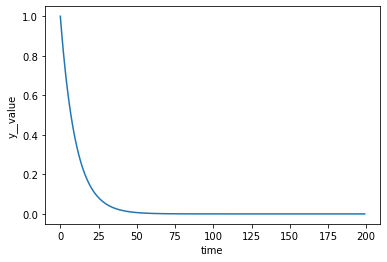

In [14]:
out_ds.y__value.plot()

# !
# !
#
# !
#
#
#
#
#
#
#
#
#
#
#
#
#

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import xsimlab as xs

# to measure process time
import time as tm

In [2]:
import attr

In [3]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra

from phydra.processes.main import ThirdInit

from phydra.processes.statevars import SV, Time

from phydra.processes.forcings import ConstantForcing

from phydra.processes.fluxes import LossLinearFlux, ForcingInputLinearFlux

from phydra.core.parts import Parameter

In [6]:
# what should the final wrapped class interface look like? 
# in what way 

# SO THE FIRST (and maybe only) way to implemented is for Fluxes!
# the basic types of fluxes have their decorators
# and each flux uses one of these decorators and
# the actual function is a simple flux function

# so how can I turn a simple (latexifiable) function, into an xs.process via decoration?

hm... so now I have this simple wrapper, but it don't make any sense..

# also no latexification as of right now, unless modifying base code

what can I do to make this more senseful?

# no. no. 
good idea: instead of mix matching base class & flux func
    
instead create abc for flux, that includes inputs outputs and parameters

and from this the proper flux PROCESS is created!

# latexify_py can be incorporated into this class! compatibility with base math

xs.variable returns attr.attrib("content here")

# 

SyntaxError: invalid syntax (<ipython-input-6-778419129297>, line 11)

In [4]:
from phydra.processes.main import ThirdInit

In [5]:
from collections import OrderedDict

In [6]:
from enum import Enum

class FluxVarType(Enum):
    STATEVARIABLE = "statevariable"
    PARAMETER = "parameter"
    FORCING = "forcing"

class FluxVarIntent(Enum):
    INPUT = "input"
    OUTPUT = "output"

In [29]:
def _make_property_flux(flux):
    return xs.variable(intent='in')


class _FluxProcessBuilder:
    """ 
    Process builder creates xs.process, from Flux base class
    """
    
    _make_prop_funcs = {
        FluxVarType.STATEVARIABLE: _make_property_flux,
        FluxVarType.PARAMETER: _make_property_flux,
        FluxVarType.FORCING: _make_property_flux,
    }
    
    def __init__(self, cls):
        print("INIT:", type(cls), cls)
        self._base_cls = ThirdInit  # handles init structure (fluxes initialized last)
        self._flux_cls = cls
        self._flux_func = cls.flux
        self._flux_cls_dict = {}
        
        # maybe here, add a dict that builds the flux function later on
        # maybe that stores input output, and parameters, forcings
        # flux cls dict stores xs.variables and setup!
    
    
    def add_properties(self):
        for var_name, var in attr.fields_dict(self._flux_cls).items():
            var_type = var.metadata.get("var_type")
            
            print("add_properties", var_type)
            
            if var_type is not None:
                make_prop_func = self._make_prop_funcs[var_type]
                print(make_prop_func(var))
                self._flux_cls_dict[var_name] = make_prop_func(var)
                
    
    def _make_xsimlab_process(self):
        print("MAKING xsimlab process")
        p_cls = attr.make_class(
            self._flux_cls.__name__,
            self._reset_attributes(),
            bases=(self._base_cls,),
            init=False,
            repr=False,
        )
        print("P_CLSS", p_cls)
        return p_cls
    
    
    def _setup_flux_func(self):
        
        print(self._flux_func)
        
        return self._flux_func
    
    
    def _setup_init_func(cls):
        
        def initialize(self):
            super(getattr(self, '__class__'), self).initialize()  # handles initialization stages
            
            print(f"initializing flux {self.label}")
            print("INIT parent wrapped class: ", cls)
            print("INIT self: ", self)
            
            print(getattr(self, '__class__'))
            
            print(getattr(self, '__xsimlab_name__'))
            
            # setup parameter
            self.m.Parameters[self.label + '_rate'] = Parameter(name=self.label + '_rate', value=self.rate)
            # create flux
            self.m.Fluxes[self.sv_label].append(self.flux)
            
        return initialize
    
    
    def create_process(self):
        
        p_cls = self._make_xsimlab_process()
        
        for name, value in self._flux_cls_dict.items():
            print("from flux cls dict", name, value)
            setattr(p_cls, name, value)
        
        setattr(p_cls, "initialize", self._setup_init_func())
        setattr(p_cls, "flux", self._setup_flux_func())
        
        return xs.process(p_cls)


In [99]:
class HELLO:
    
    x = attr.ib()

In [100]:
HELLO(1)

TypeError: HELLO() takes no arguments

In [101]:
dir(HELLO)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'x']

In [102]:
HELLOattr = attr.s(HELLO, repr=False)

In [103]:
dir(HELLOattr)

['__attrs_attrs__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__']

In [104]:
HELLOattr(1)

In [107]:
xs.process(HELLO)

__main__.HELLO

In [109]:
xs.process_info(xs.process(HELLOattr))

<HELLO  (xsimlab process)>
Variables:
    *empty*
Simulation stages:
    *no stage implemented*


In [30]:
def processfromflux(maybe_cls=None):
    
    def wrap(cls):
        print("wrapper cls", cls)
        
        attr_cls = attr.attrs(cls, repr=False)
        
        print("wrapper attr cls", attr_cls)
        
        builder = _FluxProcessBuilder(attr_cls)

        builder.add_properties()

        #if autodoc:
        #    builder.render_docstrings()

        return builder.create_process()
    
    
    if maybe_cls is None:
        return wrap
    else:
        return wrap(maybe_cls)

In [31]:
@processfromflux
class XXXX:
    sv_label = attr.ib(metadata={"var_type": FluxVarType.STATEVARIABLE})
    
    rate = attr.ib(metadata={"var_type": FluxVarType.PARAMETER})
    
    def flux(self):
        print("FLUXXING")
        print(self.sv, self.rate)
        
        
        pass
    
    #def flux(self, **kwargs):
    #    state = kwargs.get('state')
    #    parameters = kwargs.get('parameters')
    #
    #    sv = state[self.sv_label]
    #    rate = parameters[self.label + '_rate']
    #    delta = -rate * sv
    #    return delta

wrapper cls <class '__main__.XXXX'>
wrapper attr cls <class '__main__.XXXX'>
INIT: <class 'type'> <class '__main__.XXXX'>
add_properties FluxVarType.STATEVARIABLE
_CountingAttr(counter=143, _default=NOTHING, repr=True, eq=True, order=True, hash=None, init=True, metadata={'var_type': <VarType.VARIABLE: 'variable'>, 'dims': ((),), 'intent': <VarIntent.IN: 'in'>, 'groups': (), 'static': False, 'attrs': {}, 'description': '', 'encoding': {}})
add_properties FluxVarType.PARAMETER
_CountingAttr(counter=145, _default=NOTHING, repr=True, eq=True, order=True, hash=None, init=True, metadata={'var_type': <VarType.VARIABLE: 'variable'>, 'dims': ((),), 'intent': <VarIntent.IN: 'in'>, 'groups': (), 'static': False, 'attrs': {}, 'description': '', 'encoding': {}})
MAKING xsimlab process
resetting attrs
sv_label Attribute(name='sv_label', default=NOTHING, validator=None, repr=True, eq=True, order=True, hash=None, init=True, metadata=mappingproxy({'var_type': <FluxVarType.STATEVARIABLE: 'statevariable'

In [32]:
xs.process_info(XXXX)

<XXXX  (xsimlab process)>
Variables:
    m              [in] <--- ModelCore.m
    label         [out]
    firstinit      [in] <--- group 'FirstInit'
    secondinit     [in] <--- group 'SecondInit'
    group         [out]
    sv_label       [in]
    rate           [in]
Simulation stages:
    initialize


In [33]:
Model = phydra.create({
    # SV
    'y':SV,
    'x':SV, 
    
    # Fluxes
    'y_loss':XXXX,
    'x_loss':XXXX,
    
    # Forcing
    'y_input':ForcingInputLinearFlux,
    'N0':ConstantForcing
})

In [34]:
Model

<xsimlab.Model (9 processes, 12 inputs)>
Core
    solver_type     [in]
Time
    time            [in] ('input_time',) A sequence of Time points ...
y
    init            [in]
x
    init            [in]
N0
    value           [in]
y_loss
    rate            [in]
    sv_label        [in]
x_loss
    rate            [in]
    sv_label        [in]
y_input
    rate            [in]
    fx_label        [in]
    sv_label        [in]
Solver

In [35]:
#Model.visualize(show_inputs=True)

In [36]:
odeint_setup = phydra.setup('odeint', Model,
            time=np.arange(0,20,0.1),
            input_vars={
                'y__init':0.5,
                'x__init':0.5,
                
                'y_loss__sv_label':'y',
                'y_loss__rate':0.01,
                
                'x_loss__sv_label':'x',
                'x_loss__rate':0.5,
                
                'y_input':{'sv_label':'y',
                          'fx_label':'N0',
                          'rate':.1},
                'N0__value':2.
            },
            output_vars={
                'y__value':None,
                'x__value':None,
            })

In [37]:
out_ds = odeint_setup.xsimlab.run(model=Model)

initializing model core
Initializing Model Time
initializing state variable y
initializing state variable x
initializing forcing N0


RecursionError: maximum recursion depth exceeded while calling a Python object

In [28]:
out_ds.y__value.plot()
out_ds.x__value.plot()

NameError: name 'out_ds' is not defined

In [110]:
@processfromflux
class fluxxx:
    pass

fluxxx

__main__.LinearFlux

In [44]:
@xs.process
class LinearFlux(ThirdInit):
    """represents a flux in the model"""

    sv_label = xs.variable(intent='in')
    rate = xs.variable(intent='in')

    def initialize(self):
        super(LinearFlux, self).initialize()  # handles initialization stages
        print(f"initializing flux {self.label}")

        # setup parameter
        self.m.Parameters[self.label + '_rate'] = Parameter(name=self.label + '_rate', value=self.rate)
        # create flux
        self.m.Fluxes[self.sv_label].append(self.flux)

NameError: name 'ThirdInit' is not defined

In [34]:
#@phydra.flux
def flux():
    pass

In [36]:
flux()

In [89]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

In [97]:
import phydra.utility.latexify as latexify

In [98]:
def hello(a,b,c):
    return a + c/b + c

In [176]:
def flux(*, sv1, rate1):
    return sv1 * rate1 + 2

In [177]:
latexify.get_latex(flux)

'\\mathrm{flux}()\\triangleq sv1rate1 + 2'

In [39]:
@process(*args)
class HELLO:
    
    Hey = xs.variable()

NameError: name 'args' is not defined

In [35]:
xs.process_info(HELLO)

<HELLO  (xsimlab process)>
Variables:
    Hey         [in]
Simulation stages:
    *no stage implemented*


In [ ]:
def make_flux(flux_cls, flux_name):
    """
    This functions creates a properly labeled xs.process from class Component.
    :args:
        cls_name (cls): Class of forcing flux to be initialized
        dim_name (str): Name of sub-dimension of returned process, UPPERCASE!
    :returns:
        xs.process of class Component
    """
    new_dim = xs.index(dims=(flux_name), groups='flux_index')
    base_dict = dict(flux_cls.__dict__)
    base_dict[flux_name] = new_dim

    new_cls_name = flux_cls.__name__ + '_' + flux_name
    new_cls = type(new_cls_name, flux_cls.__bases__, base_dict)

    
    def initialize(self):
        super(LinearFlux, self).initialize()  # handles initialization stages
        print(f"initializing flux {self.label}")

        # setup parameter
        self.m.Parameters[self.label + '_rate'] = Parameter(name=self.label + '_rate', value=self.rate)
        # create flux
        self.m.Fluxes[self.sv_label].append(self.flux)
        
        
    def initialize_dim(self):
        r_label = getattr(self, 'R_label')
        c_label = getattr(self, 'C_label')

        cls_label = getattr(self, '__xsimlab_name__')
        setattr(self, 'cls_label', cls_label)
        print(f"flux {cls_label} is initialized for {r_label} --> {c_label}")

        setattr(self, 'flux_label', str(cls_label))
        fx_c_list = []
        for r_lab, c_lab in zip(r_label, c_label):
            if self.gk_SVshapes[r_lab].size == 1 and self.gk_SVshapes[c_lab].size == 1:
                fx_c_list.append(f"{cls_label}-{r_lab}-2-{c_lab}")
            elif self.gk_SVshapes[r_lab].size == 1:
                for c in range(self.gk_SVshapes[c_lab].size):
                    fx_c_list.append(f"{cls_label}-{r_lab}-2-{c_lab}{c}")
            else:
                for r in range(self.gk_SVshapes[r_lab].size):
                    for c in range(self.gk_SVshapes[c_lab].size):
                        fx_c_list.append(f"{cls_label}-{r_lab}{r}-2-{c_lab}{c}")

        setattr(self, flux_name, fx_c_list)

        cls_here = getattr(self, '__class__')
        super(cls_here, self).initialize_parametersetup()

        
    setattr(new_cls, 'initialize', initialize_dim)

    
    if flux_name.lower() == flux_name:
        raise ValueError(f"dimension label ({flux_name}) supplied to forcing flux {flux_cls} needs to be Upper Case")

        
    new_cls.output.metadata['dims'] = ((flux_name, 'time'),)
    return xs.process(new_cls)

In [ ]:
def make_flux(flux_cls, flux_name):
    """
    This functions creates a properly labeled xs.process from class Component.
    :args:
        cls_name (cls): Class of forcing flux to be initialized
        dim_name (str): Name of sub-dimension of returned process, UPPERCASE!
    :returns:
        xs.process of class Component
    """
    new_dim = xs.index(dims=(flux_name), groups='flux_index')
    base_dict = dict(flux_cls.__dict__)
    base_dict[flux_name] = new_dim

    new_cls_name = flux_cls.__name__ + '_' + flux_name
    new_cls = type(new_cls_name, flux_cls.__bases__, base_dict)

    def initialize_dim(self):
        r_label = getattr(self, 'R_label')
        c_label = getattr(self, 'C_label')

        cls_label = getattr(self, '__xsimlab_name__')
        setattr(self, 'cls_label', cls_label)
        print(f"flux {cls_label} is initialized for {r_label} --> {c_label}")

        setattr(self, 'flux_label', str(cls_label))
        fx_c_list = []
        for r_lab, c_lab in zip(r_label, c_label):
            if self.gk_SVshapes[r_lab].size == 1 and self.gk_SVshapes[c_lab].size == 1:
                fx_c_list.append(f"{cls_label}-{r_lab}-2-{c_lab}")
            elif self.gk_SVshapes[r_lab].size == 1:
                for c in range(self.gk_SVshapes[c_lab].size):
                    fx_c_list.append(f"{cls_label}-{r_lab}-2-{c_lab}{c}")
            else:
                for r in range(self.gk_SVshapes[r_lab].size):
                    for c in range(self.gk_SVshapes[c_lab].size):
                        fx_c_list.append(f"{cls_label}-{r_lab}{r}-2-{c_lab}{c}")

        setattr(self, flux_name, fx_c_list)

        cls_here = getattr(self, '__class__')
        super(cls_here, self).initialize_parametersetup()

    setattr(new_cls, 'initialize', initialize_dim)

    if flux_name.lower() == flux_name:
        raise ValueError(f"dimension label ({flux_name}) supplied to forcing flux {flux_cls} needs to be Upper Case")

    new_cls.output.metadata['dims'] = ((flux_name, 'time'),)
    return xs.process(new_cls)

In [49]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra

from phydra.processes.main import ThirdInit

from phydra.core.parts import Parameter

In [2]:
import xsimlab as xs

import numpy as np

In [3]:
import attr

from attr._make import _CountingAttr

In [4]:
from enum import Enum

class FluxVarType(Enum):
    STATEVARIABLE = "statevariable"
    PARAMETER = "parameter"
    FORCING = "forcing"

class FluxVarFlow(Enum):
    INPUT = "input"
    OUTPUT = "output"
    
class FluxVarIntent(Enum):
    IN = "in"
    OUT = "out"

In [53]:
def flux_sv(
    flow='input',
    intent='in',
    default=attr.NOTHING,
    validator=None,
    converter=None,
    description='',
    attrs=None,
):
    metadata = {
        "var_type": FluxVarType.STATEVARIABLE,
        "intent": FluxVarIntent(intent),
        "flow": FluxVarFlow(flow),
        "attrs": attrs or {},
        "description": description,
    }

    if FluxVarIntent(intent) == FluxVarIntent.OUT:
        _init = False
        _repr = False
    else:
        _init = True
        _repr = True

    return attr.attrib(
        metadata=metadata,
        default=default,
        validator=validator,
        converter=converter,
        init=_init,
        repr=_repr,
        kw_only=True,
    )


def flux_param(
    intent='in',
    default=attr.NOTHING,
    validator=None,
    converter=None,
    description='',
    attrs=None,
):
    metadata = {
        "var_type": FluxVarType.PARAMETER,
        "intent": FluxVarIntent(intent),
        "flow": None,
        "attrs": attrs or {},
        "description": description,
    }

    return attr.attrib(
        metadata=metadata,
        default=default,
        validator=validator,
        converter=converter,
        init=True,
        repr=True,
        kw_only=True,
    )

In [430]:
from collections import defaultdict

def _convert_2_xsimlabvar(var):
    var_description = var.metadata.get('description')
    return xs.variable(intent='in', description=var_description)



def _make_flux_sv_label(self, state):
    sv = state[self.sv1]
    
    var_flow = var.metadata.get('flow')
    return var.name

def _make_flux_parameter(var):
    var_description = var.metadata.get('description')
    return xs.variable(intent='in', description=var_description)

_make_prop_funcs = {
        FluxVarType.STATEVARIABLE: _make_flux_sv_label,
        FluxVarType.PARAMETER: _make_flux_parameter,
        FluxVarType.FORCING: _make_property_flux,
    }


def flux_decorator(cls):
    """ flux decorator 
    that converts simplified flux class into fully functional
    xarray simlab process
    """        
    new_cls_dict = defaultdict()
    flux_dict = defaultdict(list)
    
    # convert state variables, forcing and parameters to xs.variables in new process
    for var_name, var in cls.__dict__.items():
        if isinstance(var, _CountingAttr):
            var_type = var.metadata.get('var_type')
            if var_type is not None:
                new_cls_dict[var_name] = _convert_2_xsimlabvar(var)
                flux_dict[var_type].append({'name':var_name, 'metadata':var.metadata})
    
    new_cls = type(cls.__name__, (ThirdInit,), new_cls_dict)
    
    # now, get dict of all statevars, (for flux function setup)

    print("Flux dict", flux_dict)
    
    # convert flux function into functional xarray-simlab flux
    def flux(self, **kwargs):
        """linear loss flux of state variable"""
        state = kwargs.get('state')
        parameters = kwargs.get('parameters')
        
        #print(state, '\n',parameters)
        # get dict of svs, pars and forcings
        # and pass these to the cls.flux function (make sure in correct order!)
        
        sv = state[self.sv1]
        rate = parameters[self.label + '_rate1']
        
        # here collect all vars defined (values!), and pass as keyword args
        return cls.flux(sv1=sv, rate1=rate)
    
    def negative_flux(self, **kwargs):
        out = flux(self, **kwargs)
        return - out
    
    setattr(new_cls, 'flux', flux)
    setattr(new_cls, 'negative_flux', negative_flux)
    
    def initialize_flux(self):
        self.label = self.__xsimlab_name__ 
        self.group = 3  # handles initialisation stages
        print(f"initializing flux {self.label}")
        print(flux_dict.items())
        for key, varlist in flux_dict.items():
            for var in varlist:
                var_value = getattr(self, var['name'])
                
                if key is FluxVarType.PARAMETER:
                    self.m.Parameters[self.label + '_' + var['name']] = \
                            Parameter(name=self.label +  '_' + var['name'], value=var_value)
                elif key is FluxVarType.STATEVARIABLE:
                    if var['metadata']['flow'] is FluxVarFlow.OUTPUT:
                        self.m.Fluxes[var_value].append(self.negative_flux)
                    elif var['metadata']['flow'] is FluxVarFlow.INPUT:
                        self.m.Fluxes[var_value].append(self.flux)
                    elif var['metadata']['flow'] is None:
                        pass

    setattr(new_cls, 'initialize', initialize_flux)
    
    return xs.process(new_cls)

1. allow using sink + source terms (i.e. use flow attribute of sv_label)
     - think if this can be done fractionated?
     
2. use a simple flux function, that is referenced within the xs.process flux function
     - this should be latexifiable! try and make it so..

In [422]:
@flux_decorator
class FluxOne:
    sv1 = flux_sv(flow='output')
    rate1 = flux_param()
    
    def flux(sv1, rate1):
        return sv1 * rate1

Flux dict defaultdict(<class 'list'>, {<FluxVarType.STATEVARIABLE: 'statevariable'>: [{'name': 'sv1', 'metadata': {'var_type': <FluxVarType.STATEVARIABLE: 'statevariable'>, 'intent': <FluxVarIntent.IN: 'in'>, 'flow': <FluxVarFlow.OUTPUT: 'output'>, 'attrs': {}, 'description': ''}}], <FluxVarType.PARAMETER: 'parameter'>: [{'name': 'rate1', 'metadata': {'var_type': <FluxVarType.PARAMETER: 'parameter'>, 'intent': <FluxVarIntent.IN: 'in'>, 'flow': None, 'attrs': {}, 'description': ''}}]})


In [423]:
xs.process_info(FluxOne)

<FluxOne  (xsimlab process)>
Variables:
    m              [in] <--- ModelCore.m
    label         [out]
    firstinit      [in] <--- group 'FirstInit'
    secondinit     [in] <--- group 'SecondInit'
    group         [out]
    sv1            [in]
    rate1          [in]
Simulation stages:
    initialize


In [424]:
from phydra.processes.statevars import SV

In [425]:
Model = phydra.create({'y':SV, 'D':FluxOne})

Model

<xsimlab.Model (5 processes, 5 inputs)>
Core
    solver_type     [in]
Time
    time            [in] ('input_time',) A sequence of Time points ...
y
    init            [in]
D
    rate1           [in]
    sv1             [in]
Solver

In [426]:
odeint_setup = phydra.setup('odeint', Model,
            time=np.arange(0,20,0.1),
            input_vars={
                'D__sv1':'y',
                'D__rate1':1,
                
                'y__init':1
            },
            output_vars={
                'y__value':None
            })

In [427]:
out_ds = odeint_setup.xsimlab.run(model=Model)

initializing model core
Initializing Model Time
initializing state variable y
initializing flux D
dict_items([(<FluxVarType.STATEVARIABLE: 'statevariable'>, [{'name': 'sv1', 'metadata': {'var_type': <FluxVarType.STATEVARIABLE: 'statevariable'>, 'intent': <FluxVarIntent.IN: 'in'>, 'flow': <FluxVarFlow.OUTPUT: 'output'>, 'attrs': {}, 'description': ''}}]), (<FluxVarType.PARAMETER: 'parameter'>, [{'name': 'rate1', 'metadata': {'var_type': <FluxVarType.PARAMETER: 'parameter'>, 'intent': <FluxVarIntent.IN: 'in'>, 'flow': None, 'attrs': {}, 'description': ''}}])])
assembling model
SOLVER : odeint
start solve now
Model was solved in 0.0014 seconds
here unpacking values time
here unpacking values y
finalizing: cleanup


In [428]:
out_ds

<xarray.Dataset>
Dimensions:            (clock: 2, input_time: 200, time: 200)
Coordinates:
  * clock              (clock) int64 0 1
Dimensions without coordinates: input_time, time
Data variables:
    Core__solver_type  <U6 'odeint'
    D__rate1           int64 1
    D__sv1             <U1 'y'
    Time__time         (input_time) float64 0.0 0.1 0.2 0.3 ... 19.7 19.8 19.9
    y__init            int64 1
    y__value           (time) float64 1.0 0.9048 0.8187 ... 2.618e-09 2.381e-09

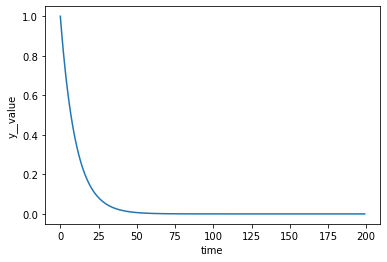

In [429]:
out_ds.y__value.plot()

# TODO

1. get a very simple example running, creating a xs.process from another decorated class, by wrapping attr.ib
# YES!

2. allow addition of
    # the SVs the flux affects (input vs output)
    - the SVs and forcing that the flux is dependent on (intent='modifier')
    - parameters, that automatically are handled

In [81]:
def hello():
    return property(1)

hello()